In [1]:
!pip install music21;

In [0]:
#tiek ieimportētas nepieciešamās bibliotēkas
from music21 import instrument, note, stream
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

In [0]:
#fja attēla pikseļu dominējošo krāsu noteikšanai
def dom_color (pic):
  pikseli = np.empty((pic.shape[0],pic.shape[1],pic.shape[2]))
  for h in range(pic.shape[0]):
    for w in range(pic.shape[1]):
      max = np.max(pic[h][w])
      for d in range(pic.shape[2]):
        if pic[h][w][d] == max:
          pikseli[h][w][d] = 1
        else:
          pikseli[h][w][d] = 0
  return pikseli

In [0]:
#fja, kas nosaka nošu garumu daļā, ja tam padod attēla daļas masīvu
def note_length (arr):
  #tiek aprēķināta krāsas intensitāte, saskaitot, cik pikseļi ir "dominējošie", un izdalot ar kopēju pikseļu skaitu
  dim = arr.shape[0]*arr.shape[1]
  dens = np.sum(arr)/dim
  #100/5=20% katram garumam
  if dens < 0.2 : return 4
  elif 0.2 <= dens < 0.4 : return 2
  elif 0.4 <= dens < 0.6 : return 1
  elif 0.6 <= dens < 0.8 : return 0.5
  else: return 0.25

In [0]:
#fja, kas nosaka nots augstumu, ja tam padod attēla daļas masīvu
def note_pitch (arr):
  dim = arr.shape[0]*arr.shape[1]
  dens = np.sum(arr)/dim
  #100/7=14.285...~14.3% notij
  if dens < 0.143 : return 0 #C
  elif 0.143 <= dens < 0.286 : return 2 #D
  elif 0.286 <= dens < 0.429 : return 4 #E
  elif 0.429 <= dens < 0.572 : return 5 #F
  elif 0.572 <= dens < 0.715 : return 7 #G
  elif 0.715 <= dens < 0.858 : return 9 #A
  else: return 11 #B

In [0]:
#fja, kas piešķir oktāvu, sākot ar mazāk izteiktai krāsai zemāko, un uz augšu (2-4)
def determine_octave (red, green, blue):
  rgb_dens = [np.sum(red), 
              np.sum(green), 
              np.sum(blue)]
  octaves = []
  rgb_sorted = sorted(rgb_dens)
  for i in range(len(rgb_sorted)):
    octaves.append(rgb_sorted.index(rgb_dens[i])+2)
  return octaves

In [0]:
#fja, kas sadala padoto 2D masīvu n vienādās daļās pa vertikālēm
def split_array (arr, n):
  x = arr.shape[0]
  y = int(arr.shape[1]/n)
  split_arr = np.empty([n,x,y])
  for i in range(n):
    split_arr[i] = arr[0:x, i*y:(i+1)*y]
  return split_arr

In [0]:
#fja nošu veidošanai
def create_music (arr, output_notes, oct):
  offset = 0
  #attēls tiek sadalīts 4 daļās
  arr_in_4 = split_array(arr, 4)
  
  #attēla daļas pa vienai tiek apstaigātas
  for arr_part in arr_in_4:
    #daļai tiek noteikts nots garums
    note_l = note_length(arr_part)

    #atkarībā no nots garuma, attēla daļa tiek sadalīta vēl sīkāk n daļās
    arr_part_in_n = split_array(arr_part,int(4/note_l))

    #katrai "apakšdaļai" tiek noteikts nots augstums un izveidots nots objekts
    for arr_subpart in arr_part_in_n:
      note_p = note_pitch(arr_subpart)
      #parametrs quarterLenght apzīmē nots garumu ceturtdaļās
      #offset ir nots atskaņošanas laiks attiecībā pret sākumu
      new_note = note.Note(note_p, quarterLength=note_l)
      new_note.offset = offset
      new_note.octave = oct
      new_note.storedInstrument = instrument.Piano()
      output_notes.append(new_note)
    
      #palielina offset katrā iterācijā, lai notis nepārklājas
      offset += note_l
  return output_notes

In [0]:
def generate(pic, fn, download=True, printMIDI=False):
  #tiek noteikta katrā pikselī dominējošā krāsa
  pix = dom_color(pic)
  #dominējošo krāsu matrica tiek sadalīta pa krāsu slāņiem
  red=pix[:, :, 0]
  green=pix[:, :, 1]
  blue=pix[:, :, 2]

  #tiek noteiktas oktāvas krāsām
  octaves = determine_octave(red, green, blue)

  #tiek veikta nošu ģenerēšana pēc kārtas katram krāsu slānim
  output = []
  create_music(red, output, octaves[0])
  create_music(green, output, octaves[1])
  create_music(blue, output, octaves[2])  

  #ģenerēto nošu informācija tiek ierakstīta failā
  midi_stream = stream.Stream(output)
  midi_stream.write('midi', fp='{name}_423.mid'.format(name=fn.split('.')[0]))

  #ģenerētā MIDI faila lejuplāde
  if download == 1:
    files.download('{name}_423.mid'.format(name=fn.split('.')[0]))

  #ģenerēto nošu izprintēšana
  if printMIDI == 1:
    for element in output:
      print(element.nameWithOctave, element.offset, element.quarterLength)

In [10]:
#attēla augšupielāde
uploaded = files.upload()

Saving burano.jpg to burano.jpg


In [20]:
#tiek nolasīts faila nosaukums un pats attēls
filename = list(uploaded.keys())[0]
uploaded_picture=plt.imread(filename)

#attēla masīvs tiek padots mūzikas ģenerēšanas fjai
generate(uploaded_picture, filename, 1s, 1)

G4 0.0 1.0
G4 1.0 1.0
F4 2.0 1.0
F4 3.0 1.0
F4 4.0 0.5
F4 4.5 0.5
F4 5.0 0.5
A4 5.5 0.5
A4 6.0 0.5
A4 6.5 0.5
A4 7.0 0.5
A4 7.5 0.5
A4 8.0 0.5
B4 8.5 0.5
A4 9.0 0.5
F4 9.5 0.5
F4 10.0 0.5
F4 10.5 0.5
G4 11.0 0.5
A4 11.5 0.5
B4 12.0 0.5
B4 12.5 0.5
A4 13.0 0.5
A4 13.5 0.5
F4 14.0 0.5
E4 14.5 0.5
F4 15.0 0.5
E4 15.5 0.5
F3 0.0 1.0
G3 1.0 1.0
G3 2.0 1.0
F3 3.0 1.0
D3 4.0 4.0
C3 8.0 4.0
D3 12.0 2.0
F3 14.0 2.0
E2 0.0 2.0
D2 2.0 2.0
D2 4.0 4.0
D2 8.0 2.0
D2 10.0 2.0
C2 12.0 4.0


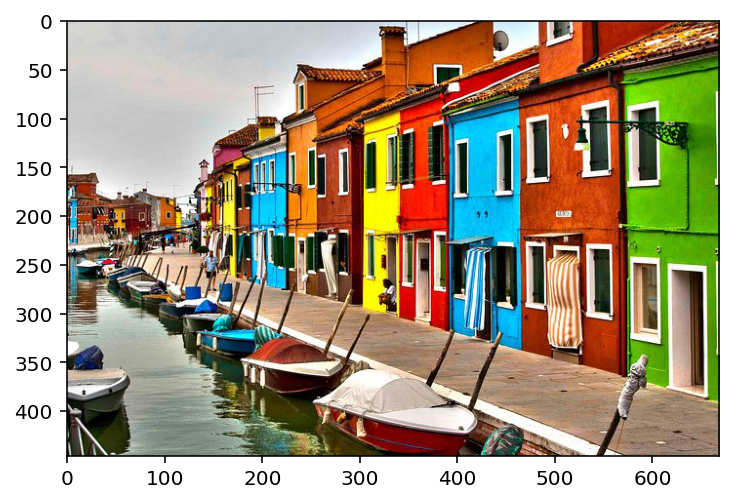

In [21]:
#iespēja attēlot attēlu, ja vajag
plt.imshow(uploaded_picture);